# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set.  Does it identify similar sentences for components 0 through 4?  

In [3]:
############## Imports ########################
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

[nltk_data] Downloading package gutenberg to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [4]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

In [5]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [6]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.20666009370456
Component 0:
" Oh !     0.999284
" Oh !"    0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
" Oh !     0.999284
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633559
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.580730
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.566441
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elto

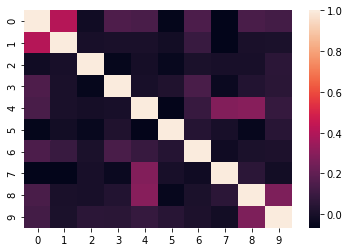

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [7]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [8]:
sim_matrix

,0,1,2,3,4,5,6,7,8,9
That is _court_ .,1.000000,0.409862,-0.018234,0.150480,0.138501,-0.055172,0.149909,-0.062690,0.141801,0.121994
""" Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me .""",0.409862,1.000000,0.001934,0.006876,0.005842,-0.014310,0.095986,-0.066408,0.007556,0.009939
""" How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .",-0.018234,0.001934,1.000000,-0.049846,-0.007562,-0.043743,0.011725,0.002437,0.000524,0.054604
"To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up her hand seized her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping fearing adoring ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being seriously accepted as soon as possible .",0.150480,0.006876,-0.049846,1.000000,0.002096,0.024346,0.139018,-0.035595,0.030891,0.050376
"Emma smiled and answered "" My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .",0.138501,0.005842,-0.007562,0.002096,1.000000,-0.060304,0.088455,0.286394,0.299443,0.086760
"A very few minutes more , however , completed the present trial .",-0.055172,-0.014310,-0.043743,0.024346,-0.060304,1.000000,0.038459,0.000499,-0.048596,0.049392
""" I am delighted to hear you speak so stoutly on the subject ,"" replied Emma , smiling ; "" but you do not mean to deny that there was a time and not very distant either when you gave me reason to understand that you did care about him ?""",0.149909,0.095986,0.011725,0.139018,0.088455,0.038459,1.000000,-0.021576,0.008740,0.015052
""" Very well ; and if he had intended to give her one , he would have told her so .""",-0.062690,-0.066408,0.002437,-0.035595,0.286394,0.000499,-0.021576,1.000000,0.055326,-0.016109
"Some laughed , and answered good - humouredly .",0.141801,0.007556,0.000524,0.030891,0.299443,-0.048596,0.008740,0.055326,1.000000,0.274250
""" There appeared such a perfectly good understanding among them all "" he began rather quickly , but checking himself , added , "" however , it is impossible for me to say on what terms they really were how it might all be behind the scenes .",0.121994,0.009939,0.054604,0.050376,0.086760,0.049392,0.015052,-0.016109,0.274250,1.000000


In [10]:
# Apply LSA Model to the test set
lsa.fit_transform(X_train_tfidf)
X_test_lsa = X_train_lsa.predict(X_test_tfidf)
#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
# paras_by_component=pd.DataFrame(X_train_lsa,index=X_test_tfidf)
# for i in range(5):
#     print('Component {}:'.format(i))
#     print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

AttributeError: 'Normalizer' object has no attribute 'predict'